In [11]:
#!pip install opendatasets
#or 
#pip install opendatasets --upgrade
import opendatasets as op

In [13]:
#Download dataset here
op.download("https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp")

Skipping, found downloaded files in ".\emotions-dataset-for-nlp" (use force=True to force download)


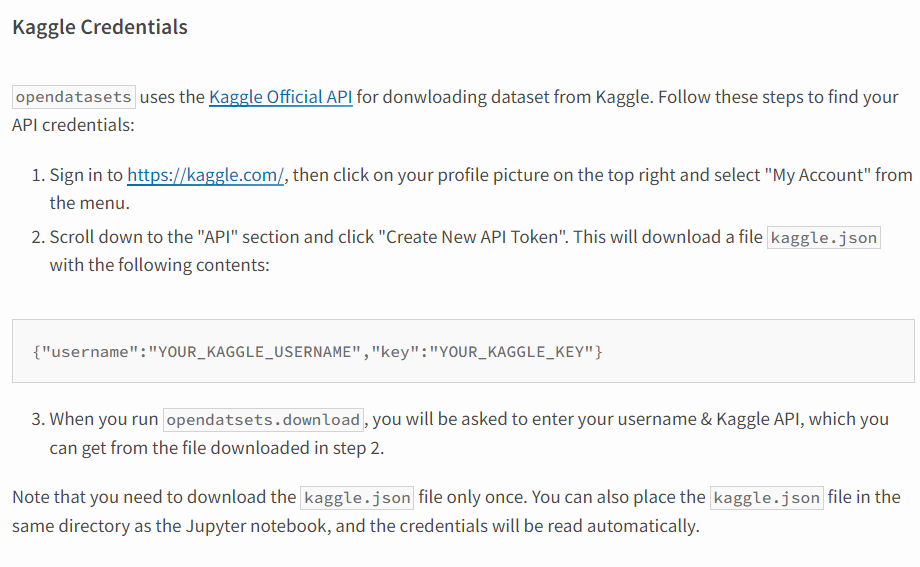

In [26]:
dataset_emotion = "emotions-dataset-for-nlp"
!pip install tensorflow

In [27]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM ,Conv2D, Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib as mpl

In [28]:
#Building recurrent neural network capable of analyzing emotions
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
port = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
class Emotion:
  def __init__(self, datasetFolder, batch_size, validation_split, optimizer, loss, epochs):
    self.datasetFolder = datasetFolder
    self.batch_size = batch_size
    self.validation_split = validation_split
    self.optimizer = optimizer
    self.loss = loss
    self.epochs = epochs
  def readDatasetCSV(self):
    trainDataset = pd.read_csv(os.path.join(self.datasetFolder, "train.txt"), names=['Text', 'Emotion'], sep=';')
    testDataset = pd.read_csv(os.path.join(self.datasetFolder, "test.txt"), names=['Text', 'Emotion'], sep=';')
    validDataset = pd.read_csv(os.path.join(self.datasetFolder, "val.txt"), names=['Text', 'Emotion'], sep=';')
    list_dataset = [trainDataset, testDataset, validDataset]
    self.dataset = pd.concat(list_dataset)
  def FeaturesLables(self):
    self.features = self.dataset['Text']
    self.labels = self.dataset['Emotion']  
  def splitDataset(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.features,
                                                                            self.labels, 
                                                                            test_size = self.validation_split)
  def CleanFeatures(self):
    self.features = self.features.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
    self.features = self.features.apply(lambda wrd: ''.join(wrd))
  def tokenizerDataset(self):
    self.tokenizer = Tokenizer(num_words=5000)
    self.tokenizer.fit_on_texts(self.features)
    train = self.tokenizer.texts_to_sequences(self.features)
    self.features = pad_sequences(train)
    le = LabelEncoder()
    self.labels = le.fit_transform(self.labels)
    self.vocabulary = len(self.tokenizer.word_index)
  def label_categorical(self):
    self.labels = to_categorical(self.labels, 6)
  def glove_word_embedding(self, file_name):
    self.embeddings_index = {}
    file_ = open(file_name)
    for line in file_:
        arr = line.split()
        single_word = arr[0]
        w = np.asarray(arr[1:],dtype='float32')
        self.embeddings_index[single_word] = w
    file_.close()
    max_words = self.vocabulary + 1
    word_index = self.tokenizer.word_index
    self.embedding_matrix = np.zeros((max_words,300)).astype(object)
    for word , i in word_index.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector  
  def model(self):
    m = Sequential()
    m.add(Input(shape=(self.features.shape[1], )))
    m.add(Embedding(self.vocabulary + 1,300))
    m.add(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    m.add(Dense(6, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    self.m = m
  def compiler(self):
    self.m.compile(loss= self.loss,optimizer=self.optimizer,metrics=['accuracy'])
  def fit(self):
    earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
    self.history_training = self.m.fit(self.X_train, self.Y_train, epochs= self.epochs,batch_size = self.batch_size,
                                       callbacks=[ earlyStopping])

In [30]:
emotion = Emotion(dataset_emotion, 256, 0.1, 'adam', 'categorical_crossentropy', 120)

In [31]:
emotion.readDatasetCSV()

In [32]:
emotion.dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [33]:
emotion.FeaturesLables()

In [34]:
emotion.CleanFeatures()

In [40]:
emotion.dataset

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [43]:
emotionpd = pd.DataFrame(emotion.dataset)

In [46]:
emotionpd

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [ ]:
#End of data representation